In [1]:
%run ../processing/read_data.py
%run ../processing/functions.ipynb

import numpy as np
import pandas as pd
import os
from PIL import Image

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn import model_selection

In [44]:
from __future__ import absolute_import, division, print_function
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Conv3D, MaxPooling3D, ZeroPadding3D
# Helper libraries
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


In [3]:
path_to_read = '../../data/dl_marcelo_perc/'
files = []

for r, d, f in os.walk(path_to_read):
    for file in f:
        if '.png' in file:
            files.append(os.path.join(r, file))
files.sort()
np_files = np.asarray(files)

In [4]:
len(np_files)

84954

In [5]:
conversion = {'IIL_' : 5, 'IIP_' : 7, '_II_' : 4, 'IIn_' : 6, '_Ia_' : 0, '_Ib_' : 1, 'Ibc_' : 2, '_Ic_' : 3}
conversion_bool = {'IIL_' : 0, 'IIP_' : 0, '_II_' : 0, 'IIn_' : 0, '_Ia_' : 1, '_Ib_' : 0, 'Ibc_' : 0, '_Ic_' : 0}


In [6]:
c = [0,0,0,0]
idx = []
i = 0
while i < len(np_files):
    if 'desg' in np_files[i]:
        c[0] = 1
    if 'desi' in np_files[i+1]:
        c[1] = 1
    if 'desr' in np_files[i+2]:
        c[2] = 1
    if 'desz' in np_files[i+3]:
        c[3] = 1
    if c == [1,1,1,1]:
        i = i + 4
        c = [0,0,0,0]
    elif c[1] == 0:
        idx.append(i)
        i = i+1
    elif c[2] == 0:
        idx.append(i)
        idx.append(i+1)
        i = i+2
    elif c[3] == 0:
        idx.append(i)
        idx.append(i+1)  
        idx.append(i+2)
        i = i+3

In [7]:
np_files = np.delete(np_files, idx)
len(np_files)

84928

In [8]:
np_grouped = np_files.reshape(round(np_files.shape[0]/4), 4)
class_id = []
#CHANGE HERE THE INDEX EVERYTIME WE CHANGE THE NAME FROM THE PATH OF THE FOLDER
for g in np_grouped:
    class_id = class_id + [[g[0][-20:-12], g[0][-12:-8]]] 
types = []
types_bool = []
for ids in class_id:
    types = types + [conversion[ids[1]]]
    types_bool = types_bool + [conversion_bool[ids[1]]]
    
astr_objs = []
for i in range(len(np_grouped)):
    astr_objs = astr_objs + [class_id[i]]
    for file in np_grouped[i]:
        img = Image.open(file).convert('L')
        arr = np.array(img)
        astr_objs[-1] = astr_objs[-1] + [arr[5:35,10:56]] 
        #CHANGE HERE IF WE EVENTUALLY CHANGE THE SIZE OF THE IMAGE, OR WANT TO CUT OTHER FRAMES

print( "The quantity of objects is: ", len(astr_objs))

The quantity of objects is:  21232


# K-FOLD

In [9]:
labels = []
images = []
ids = []
for o in astr_objs:
    labels.append((conversion_bool[o[1]])) #converting here to numbers to assure label in training
    images.append(o[2:])
    ids.append(o[0])
labels = np.asarray(labels)
images = np.asarray(images)
ids = np.asarray(ids)

Xb = images
yb = labels
kfb = KFold(n_splits=5)
Xb_train = []
Xb_test = []
yb_train = []
yb_test = []
id_train = []
id_test = []
for train_index, test_index in kfb.split(Xb):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xb_train.append(Xb[train_index])
    Xb_test.append(Xb[test_index])
    yb_train.append(yb[train_index])
    yb_test.append(yb[test_index])
    id_train.append(ids[train_index])
    id_test.append(ids[test_index])

TRAIN: [ 4247  4248  4249 ... 21229 21230 21231] TEST: [   0    1    2 ... 4244 4245 4246]
TRAIN: [    0     1     2 ... 21229 21230 21231] TEST: [4247 4248 4249 ... 8491 8492 8493]
TRAIN: [    0     1     2 ... 21229 21230 21231] TEST: [ 8494  8495  8496 ... 12737 12738 12739]
TRAIN: [    0     1     2 ... 21229 21230 21231] TEST: [12740 12741 12742 ... 16983 16984 16985]
TRAIN: [    0     1     2 ... 16983 16984 16985] TEST: [16986 16987 16988 ... 21229 21230 21231]


In [10]:
print('The shapes of the objects are:')
print('ids: ', ids.shape)
print('labels: ', labels.shape)
print('images: ', images.shape)
print('train_images: ', Xb_train[0].shape)
print('Other useful object: "test_images"')

The shapes of the objects are:
ids:  (21232,)
labels:  (21232,)
images:  (21232, 4, 30, 46)
train_images:  (16985, 4, 30, 46)
Other useful object: "test_images"


In [11]:
#This cell bugs the pc a little
#Normalization and separating the folds to the models
train_images = np.around(Xb_train[0]/255, decimals = 2)
test_images = np.around(Xb_test[0]/255, decimals = 2)

train_swaped = np.swapaxes(train_images,1,3)
test_swaped = np.swapaxes(test_images,1,3)



train_images4 = np.around(Xb_train[4]/255, decimals = 2)
test_images4 = np.around(Xb_test[4]/255, decimals = 2)

train_swaped4 = np.swapaxes(train_images4,1,3)
test_swaped4 = np.swapaxes(test_images4,1,3)

# Model Convolution NN 2D

In [20]:
np.random.seed(9)
img_rows, img_cols = 30, 46
input_shape = (img_cols, img_rows, 4)

model_cv = Sequential()

model_cv.add(Conv2D(64, kernel_size=(4,4), padding='same', activation='relu', input_shape=input_shape))
model_cv.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
model_cv.add(MaxPooling2D(pool_size=(2,2)))
model_cv.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
model_cv.add(MaxPooling2D(pool_size=(2,2)))


model_cv.add(Flatten())
model_cv.add(Dense(2, activation=tf.nn.softmax))

model_cv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 46, 30, 64)        4160      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 46, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 15, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 23, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 7, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4928)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 9858      
Total para

In [21]:
np.random.seed(9)
model_cv.compile(optimizer='adam', #optimizer = 'adadelta'
              loss='sparse_categorical_crossentropy', #loss = "binary_crossentropy"
              metrics=['accuracy'])

In [22]:
np.random.seed(9)
model_cv.fit(train_swaped, yb_train[0], #validation_split = 0.1
             epochs=10) 

Epoch 1/10
16985/16985 [==============================] - 132s 8ms/sample - loss: 0.4507 - acc: 0.7834
Epoch 2/10
16985/16985 [==============================] - 136s 8ms/sample - loss: 0.3597 - acc: 0.8218
Epoch 3/10
16985/16985 [==============================] - 114s 7ms/sample - loss: 0.3404 - acc: 0.8341
Epoch 4/10
16985/16985 [==============================] - 126s 7ms/sample - loss: 0.3224 - acc: 0.8439
Epoch 5/10
16985/16985 [==============================] - 126s 7ms/sample - loss: 0.3063 - acc: 0.8543
Epoch 6/10
16985/16985 [==============================] - 114s 7ms/sample - loss: 0.2984 - acc: 0.8578
Epoch 7/10
16985/16985 [==============================] - 100s 6ms/sample - loss: 0.2954 - acc: 0.8584
Epoch 8/10
16985/16985 [==============================] - 102s 6ms/sample - loss: 0.2845 - acc: 0.8676
Epoch 9/10
16985/16985 [==============================] - 97s 6ms/sample - loss: 0.2774 - acc: 0.8704
Epoch 10/10
16985/16985 [==============================] - 102s 6ms/sample

### With Kfold 4

In [50]:
np.random.seed(9)
img_rows, img_cols = 30, 46
input_shape = (img_cols, img_rows, 4)

model_cv4 = Sequential()

model_cv4.add(Conv2D(64, kernel_size=(4,4), padding='same', activation='relu', input_shape=input_shape))
model_cv4.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
model_cv4.add(MaxPooling2D(pool_size=(2,2)))
model_cv4.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
model_cv4.add(MaxPooling2D(pool_size=(2,2)))


model_cv4.add(Flatten())
model_cv4.add(Dense(2, activation=tf.nn.softmax))

model_cv4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 46, 30, 64)        4160      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 46, 30, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 15, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 23, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 7, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4928)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 9858      
Total para

In [51]:
np.random.seed(9)
model_cv4.compile(optimizer='adam', #optimizer = 'adadelta'
              loss='sparse_categorical_crossentropy', #loss = "binary_crossentropy"
              metrics=['accuracy'])

In [52]:
np.random.seed(9)
model_cv4.fit(train_swaped4, yb_train[4], #validation_split = 0.1
             epochs=10) 

Epoch 1/10
16986/16986 [==============================] - 107s 6ms/sample - loss: 0.4687 - acc: 0.7786
Epoch 2/10
16986/16986 [==============================] - 114s 7ms/sample - loss: 0.3693 - acc: 0.8112
Epoch 3/10
16986/16986 [==============================] - 106s 6ms/sample - loss: 0.3474 - acc: 0.8285
Epoch 4/10
16986/16986 [==============================] - 108s 6ms/sample - loss: 0.3283 - acc: 0.8384
Epoch 5/10
16986/16986 [==============================] - 111s 7ms/sample - loss: 0.3092 - acc: 0.8531
Epoch 6/10
16986/16986 [==============================] - 117s 7ms/sample - loss: 0.3004 - acc: 0.8568
Epoch 7/10
16986/16986 [==============================] - 118s 7ms/sample - loss: 0.2943 - acc: 0.8611
Epoch 8/10
16986/16986 [==============================] - 352s 21ms/sample - loss: 0.2858 - acc: 0.8683
Epoch 9/10
16986/16986 [==============================] - 286s 17ms/sample - loss: 0.2755 - acc: 0.8712
Epoch 10/10
16986/16986 [==============================] - 282s 17ms/sa

# Evaluation

In [55]:
test_loss_cv, test_acc_cv = model_cv.evaluate(test_swaped, yb_test[0])

print('Test accuracy model_cv:', test_acc_cv)
print('Test loss model_cv:', test_loss_cv)

4247/4247 [==============================] - 52s 12ms/sample - loss: 0.2905 - acc: 0.8656
Test accuracy model_cv: 0.8655521
Test loss model_cv: 0.290524958609861


In [56]:
test_loss_cv4, test_acc_cv4 = model_cv4.evaluate(test_swaped4, yb_test[4])

print('Test accuracy model_cv:', test_acc_cv4)
print('Test loss model_cv:', test_loss_cv4)

4246/4246 [==============================] - 55s 13ms/sample - loss: 0.3014 - acc: 0.8490
Test accuracy model_cv: 0.84903437
Test loss model_cv: 0.30137312290132806


# Confusion Matrices

In [57]:
def transform(pred):
    pred_bool = []
    for i in pred:
        if i[0] > i[1]:
            pred_bool.append(0)
        else:
            pred_bool.append(1)
    return pred_bool

Normalized confusion matrix
[[0.9080283  0.0919717 ]
 [0.27309237 0.72690763]]


<IPython.core.display.Javascript object>


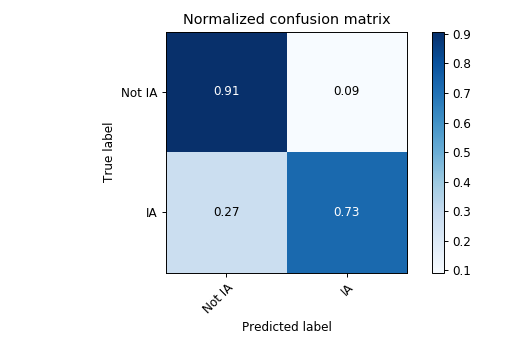

Confusion matrix, without normalization
[[2952  299]
 [ 272  724]]


<IPython.core.display.Javascript object>


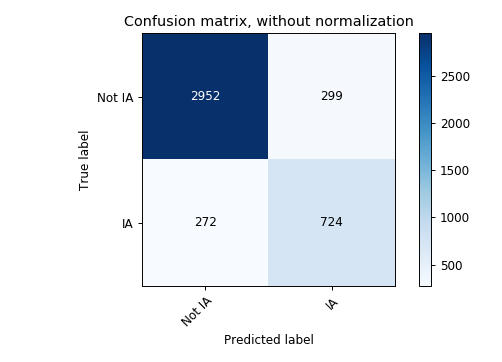

In [58]:
pred = model_cv.predict(test_swaped)
pred_bool = transform(pred)
y_true = yb_test[0]
plot_confusion_matrix(y_true, pred_bool, ['Not IA', 'IA'],normalize=True )
plot_confusion_matrix(y_true, pred_bool, ['Not IA', 'IA'],normalize=False )

Normalized confusion matrix
[[0.9211425  0.0788575 ]
 [0.37756098 0.62243902]]


<IPython.core.display.Javascript object>


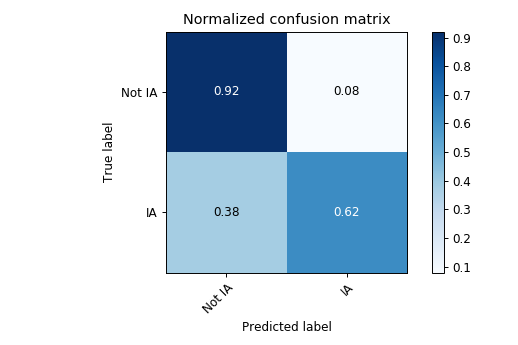

Confusion matrix, without normalization
[[2967  254]
 [ 387  638]]


<IPython.core.display.Javascript object>


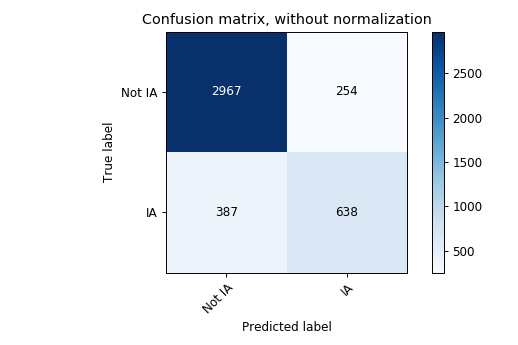

In [60]:
pred4 = model_cv4.predict(test_swaped4)
pred_bool4 = transform(pred4)
y_true4 = yb_test[4]
plot_confusion_matrix(y_true4, pred_bool4, ['Not IA', 'IA'],normalize=True )
plot_confusion_matrix(y_true4, pred_bool4, ['Not IA', 'IA'],normalize=False )